# Ensambles paralelos

Los métodos de ensambles paralelos entrenan estimadores (clasificador o regresor) débiles de forma independiente y luego combinan sus resultados. Algunas definiciones:

Estimador débil
: Algoritmo que produce un resultado (al menos) levemente mejor que el azar 

Estimador fuerte
: Algoritmo que produce un resultado correcto en la mayoría de los ejemplos

Nos enfocaremos principalmente en el caso de clasificación.

:::{important}

El supuesto principal de los ensambles paralelos es que los clasificadores débiles tienen error de generalización independiente. De lo contrario no habría ganancia al combinarlos.

:::

Si definimos el error de generalización de un clasificador débil como

$$
\epsilon_t = P(h_t(x) \neq y)
$$

y asumiendo un clasificador binario fuerte construido mediante "voto por mayoría"

$$
H(x) = \text{signo} \left( \sum_{t=1}^T h_t(x) \right)
$$

entonces se puede mostrar que

$$
P(H(x) \neq y) = \sum_{k=0}^{T/2} \binom{T}{k} (1-\epsilon)^k \epsilon^{T-k} \leq \exp \left( -\frac{1}{2} T(2\epsilon -1)^2 \right)
$$

:::{important}

Si los errores de generalización son independientes, el error del clasificador fuerte se reduce exponencialmente con la cantidad de clasificadores débiles.

:::

:::{warning}

En la práctica no es posible tener clasificadores independientes si están entrenados con el mismo conjunto de datos.

:::

A continuación veremos una técnica que busca solucionar este problema.

## Bagging: Bootstrap Aggregating

*Bootstrap* es una técnica estadística para obtener intervalos de confianza empíricos que se basa en obtener muestras distintas pero representativas del conjunto de datos original.

La técnica más clásica y simple para lograr lo anterior es **muestreo con reemplazo** y se ilustra en la siguiente figura.

<img src="img/bootstrap.png" width="700">

El conjunto de datos original (izquierda) se remuestrea $T$ veces. En cada muestra se escogen aleatoriamente tantos ejemplos como existían en el conjunto original. Sin embargo algunos ejemplos no se escogen, mientras que otros se escogen más de una vez.


El algoritmo de [Bagging](https://link.springer.com/article/10.1007/BF00058655) consiste en:

1. Generar $T$ conjuntos de datos utilizando muestreo con reemplazo
1. Entrenar un clasificador débil en cada conjunto
1. Combinar los clasificadores débiles con:

$$
H(x) = \text{arg} \max_{y \in \mathcal{Y}} \sum_{t=1}^T \mathbb{1} (h_t(x) = y)
$$

donde $\mathbb{1}(\cdot)$ es la función indicadora, que es 1 si su argumento es cierto y 0 en el caso contrario.

Lo anterior se conoce como "voto por mayoría", ya que se escoge la etiqueta que fue mayormente seleccionada por los clasificadores débiles.

:::{note}

El procedimiento anterior es amigable con arquitecturas computacionales de múltiples procesadores pues cada entrenamiento es independiente de los demás.

:::

**Ejemplos oob**

Cuando se utiliza muestreo con reemplazo la probabilidad de que el ejemplo $i$ sea incluido al menos una vez es 0.632 (se distribuye Poisson con $\lambda=1$)

Por lo tanto, por cada clasificador, hay un $36.8 \%$ de ejemplos que no se ocupan. Estos ejemplos se denominan *out-of-bag* (oob).

:::{note}

Una ventaja de bagging es que podemos utilizar los ejemplos oob de cada clasificador débil para medir el error de generalización.

:::

**Clasificador inestable**

Existe un traslape considerable entre los conjuntos remuestreados ($63.2 \%$).

Clasificador estable
: Se refiere a un clasificador que es insensible a perturbaciones en el dataset

En el caso de bagging, si los clasificadores débiles son estables, entonces su resultado será muy similar y por ende no habrá ganancia al construir un ensamble.

:::{important}

Bagging es una técnica que promedia clasificadores débiles, es decir reduce varianza. Por ende funcionará mejor con clasificadores débiles de bajo sesgos (error) pero alta varianza.

:::


:::{note}

En el caso de los árboles de decisión, mientras más profundo sea mayor inestabilidad se tiene. Adicionalmente, si los árboles no se podan son más inestables.

:::

## Random Forest

En bagging se realiza muestreo con reemplazo de los datos. [Random Forest](https://link.springer.com/article/10.1023/A:1010933404324) (RF) extiende esta idea realizando submuestreo de los atributos (features/características).

En particular, cada split de cada clasificador débil (árbol) tiene acceso a un subconjunto aleatorio $M$ de los atributos originales. De esta forma se obtienen clasificadores débiles menos correlacionados (más independientes) y además más rápidos de entrenar.

:::{note}

La cantidad máxima de atributos por *split* es un hiperparámetro. Típicamente se utiliza la raíz cuadrada del total de atributos.

:::

## Implementación en scikit-learn

El módulo [`ensemble`](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.ensemble) de scikit-learn tiene implementaciones de *RandomForest* para problemas de clasificación y regresión. Nos enfocaremos en el primero.

Los principales argumentos de [`RandomForestClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) son:

- `n_estimators`: Cantidad de clasificadores débiles (árboles)
- `max_features`: Cantidad máxima de atributos por split
- `bootstrap`: Booleano que indica si se realiza muestreo con reeplazo de los datos (por defecto `True`)
- `n_jobs`: Número de nucleos de CPU
- `class_weight`: Permite ponderar la importancia de las clases (útil para desbalance moderado)

También recibe argumentos relacionados a los clasificadores débiles (árboles), entre ellos:

- `criterion`:  Criterio para realizar la separación (split), `'entropy'` o `'gini'`
- `max_depth`: Profundidad máxima de los árboles
- `min_samples_split`: Número mínimo de muestras para permitir un `split`



Entrenemos un Random Forest para clasificar el dataset de vinos:

In [1]:
import numpy as np
from sklearn.datasets import load_wine
from sklearn.model_selection import train_test_split

data_struct = load_wine()
X = data_struct.data
y = data_struct.target
X_names = data_struct.feature_names

np.random.seed(0)
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, test_size=0.3)

In [2]:
%%time

from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

params = {'criterion':('entropy', 'gini'),
          'max_depth':[1, 5, 10, 20, None],
          'n_estimators': [1, 10, 20, 50, 100],
          'max_features': ['sqrt', 5, 10]}

model = RandomForestClassifier(n_jobs=4)
validator = GridSearchCV(model, params, cv=3, refit=True)
validator.fit(X_train, y_train)

CPU times: user 21.7 s, sys: 1.52 s, total: 23.2 s
Wall time: 27.8 s


GridSearchCV(cv=3, estimator=RandomForestClassifier(n_jobs=4),
             param_grid={'criterion': ('entropy', 'gini'),
                         'max_depth': [1, 5, 10, 20, None],
                         'max_features': ['sqrt', 5, 10],
                         'n_estimators': [1, 10, 20, 50, 100]})

Los mejores modelos de acuerdo a la validación cruzada son:

In [3]:
import pandas as pd

columns = ["param_criterion", "param_max_depth", "param_n_estimators", "param_max_features",
           "mean_test_score", "std_test_score", "rank_test_score"]
pd.DataFrame(validator.cv_results_)[columns].sort_values(by="rank_test_score").head(5)

,param_criterion,param_max_depth,param_n_estimators,param_max_features,mean_test_score,std_test_score,rank_test_score
136,gini,None,10,sqrt,0.976190,0.033672,1
122,gini,20,20,sqrt,0.976190,0.033672,1
63,entropy,None,50,sqrt,0.975997,0.019442,3
124,gini,20,100,sqrt,0.975997,0.019442,3
127,gini,20,20,5,0.975997,0.019442,3


El mejor Random Forest es:

In [4]:
validator.best_params_

{'criterion': 'gini',
 'max_depth': 20,
 'max_features': 'sqrt',
 'n_estimators': 20}

:::{note}

Random Forest prefiere árboles más profundos. Los árboles profundos tienen con bajo sesgo y alta varianza.

:::

El resultado en el conjunto de test es:

In [5]:
from sklearn.metrics import classification_report

best_rf =  validator.best_estimator_
print(classification_report(y_test, best_rf.predict(X_test)))

              precision    recall  f1-score   support

           0       0.95      0.95      0.95        19
           1       0.95      0.91      0.93        22
           2       0.93      1.00      0.96        13

    accuracy                           0.94        54
   macro avg       0.94      0.95      0.95        54
weighted avg       0.94      0.94      0.94        54



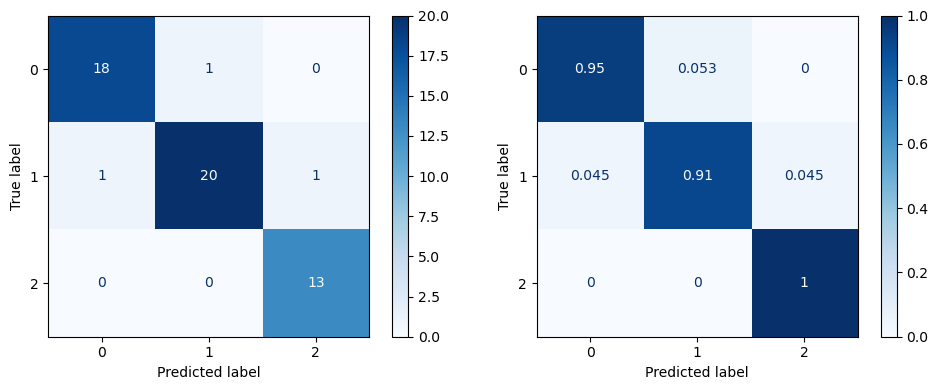

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

fig, ax = plt.subplots(1, 2, figsize=(10, 4), tight_layout=True)

ConfusionMatrixDisplay.from_predictions(y_test, validator.predict(X_test), normalize=None,
                                        ax=ax[0], cmap='Blues', colorbar=True);

ConfusionMatrixDisplay.from_predictions(y_test, validator.predict(X_test), normalize='true',
                                        ax=ax[1], cmap='Blues', colorbar=True);

## Selección de características embebida

En cada split de cada árbol se obtiene una ganancia de información para el atributo seleccionado. Luego, para un atributo en particular, se puede obtener su ganancia de información promedio. 

:::{note}

Un atributo que es más relevante (permite clasificar mejor), será escogido por una mayor cantidad de splits y por ende tendrá ganancia de información promedio mayor.

:::

Se puede utilizar la ganancia de información promedio para hacer selección de características, sin embargo existe una limitación importante: El RF no detecta correlaciones entre atributos.

:::{warning}

Si dos atributos están altamente correlacionados el RF no preferirá ninguna de ellas y la ganancia de información promedio de ambos será baja.

:::

Para el ejemplo anterior se tiene:

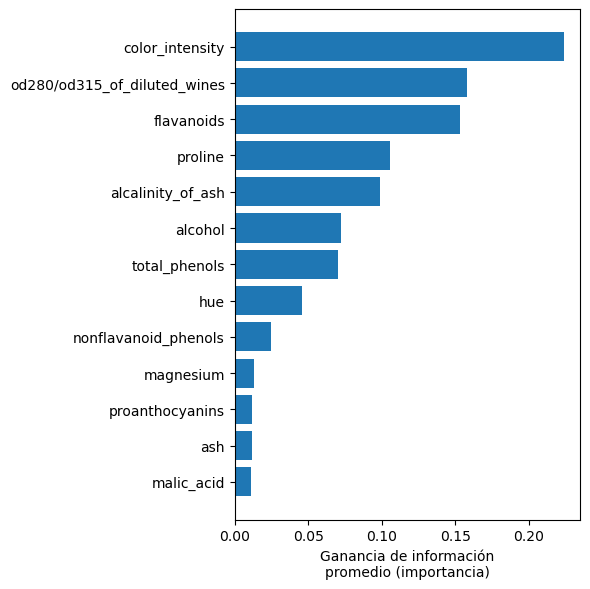

In [7]:
idx_sort = np.argsort(best_rf.feature_importances_)

fig, ax = plt.subplots(figsize=(6, 6), tight_layout=True)
ax.barh(np.array(X_names)[idx_sort], best_rf.feature_importances_[idx_sort], align='center')
ax.set_xlabel('Ganancia de información\npromedio (importancia)');